In [2]:
from ROOT import TH1F, TCanvas, gStyle, TLegend, TGraph
from sklearn.externals import joblib
from array import array
import pickle
from scipy.stats import ks_2samp
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LocallyConnected1D
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
import pandas as pd

def prepPlot(_ax, xtitle, ytitle):
    _ax.grid(False)
    _ax.set_xlabel(xtitle)
    _ax.set_ylabel(ytitle)
    _ax.set_title("")

trainFraction = 0.5

print ('Loading signal data file...')
sig_data = pd.read_hdf('/Users/sbenson/Documents/STBC-Drive/sbenson/Jets/sig_centred_imagedl.h5', start=0, end = 5000)
print ('Loading background data file...')
bkg_data = pd.read_hdf('/Users/sbenson/Documents/STBC-Drive/sbenson/Jets/bkg_centred_imagedl.h5', start=0, end = 5000)
#


Using TensorFlow backend.


Loading signal data file...
Loading background data file...


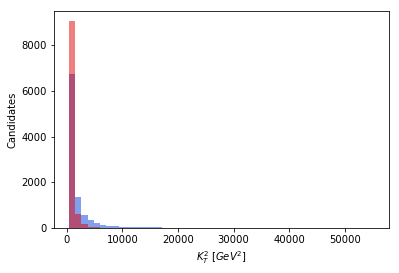

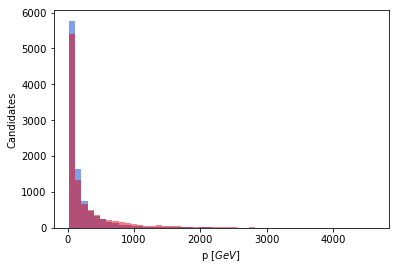

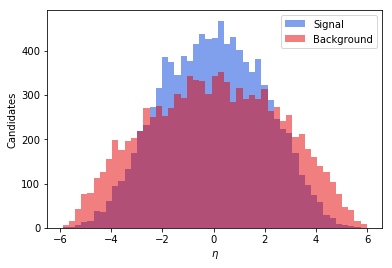

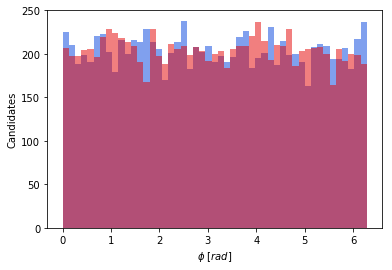

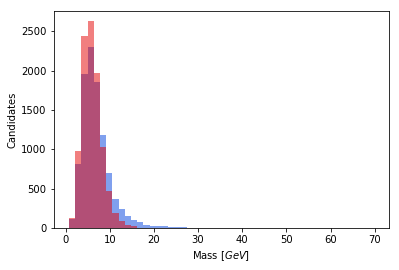

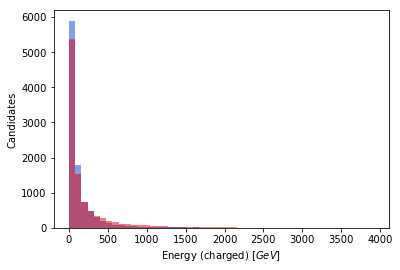

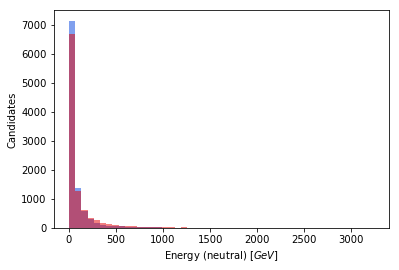

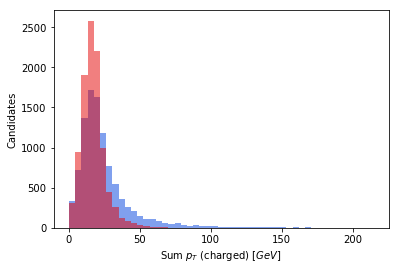

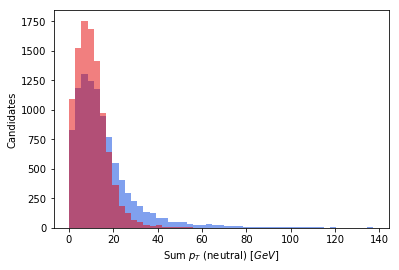

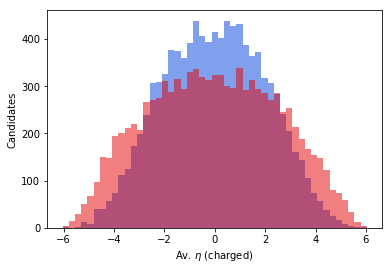

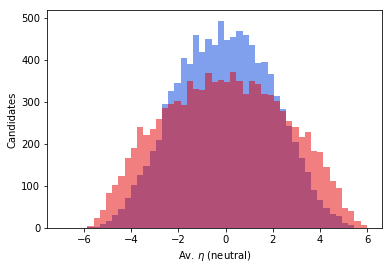

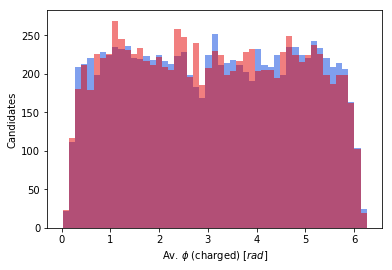

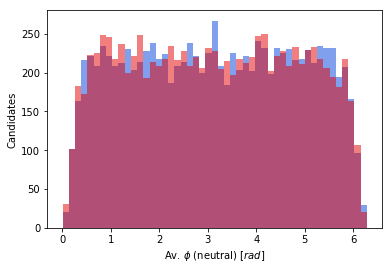

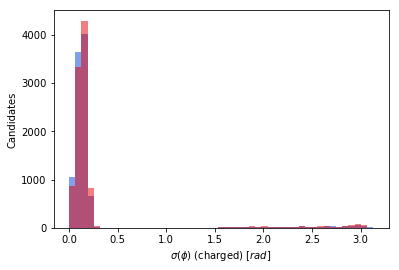

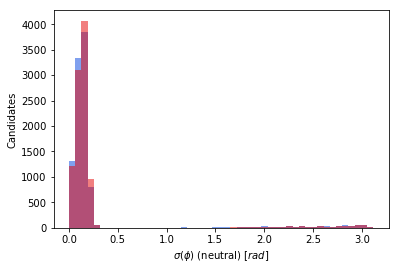

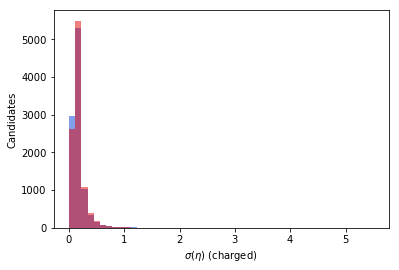

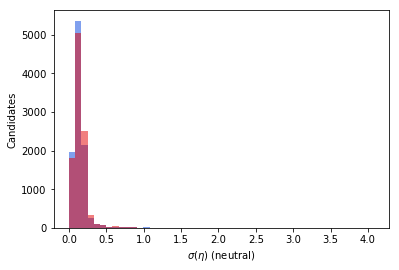

In [23]:
#print(sig_data.head(5))
#print(bkg_data.head(5))
#print(list(sig_data))
#print(list(bkg_data))

def addRMSDev(df):
    df['phi_spread_charged'] = df.apply(lambda x: np.std(x['charged_phi']), axis = 1)
    df['eta_spread_charged'] = df.apply(lambda x: np.std(x['charged_eta']), axis = 1)
    df['phi_spread_neutral'] = df.apply(lambda x: np.std(x['neutral_phi']), axis = 1)
    df['eta_spread_neutral'] = df.apply(lambda x: np.std(x['neutral_eta']), axis = 1)
    return df

sig_data_p = addRMSDev(sig_data)
bkg_data_p = addRMSDev(bkg_data)

vars_for_training = ['kt2', 'mom', 'eta', 'phi', 'mass', 'hEnergy', 'nEnergy'
                    ,'hSumPT', 'nSumPT', 'hAvEta', 'nAvEta', 'hAvPhi', 'nAvPhi'
                    , 'phi_spread_charged', 'phi_spread_neutral', 'eta_spread_charged', 'eta_spread_neutral']
xlabels = ['$K_T^2$ [$GeV^2$]', 'p [$GeV$]', '$\eta$', '$\phi$ [$rad$]', 'Mass [$GeV$]', 'Energy (charged) [$GeV$]'
           , 'Energy (neutral) [$GeV$]'
                    ,'Sum $p_{T}$ (charged) [$GeV$]', 'Sum $p_{T}$ (neutral) [$GeV$]'
           , 'Av. $\eta$ (charged)', 'Av. $\eta$ (neutral)', 'Av. $\phi$ (charged) [$rad$]', 'Av. $\phi$ (neutral) [$rad$]'
                    , '$\sigma(\phi)$ (charged) [$rad$]', '$\sigma(\phi)$ (neutral) [$rad$]'
           , '$\sigma(\eta)$ (charged)', '$\sigma(\eta)$ (neutral)']

for m, var in enumerate(vars_for_training):
    plt.clf()
    fig, axes = plt.subplots()
    bins = np.linspace(bkg_data_p[var].min(), bkg_data_p[var].max(), 50)
    h_sig = sig_data_p.sample(10000).hist(column=[var], ax = axes, color = "xkcd:blue", label = "Signal", bins = bins, alpha=0.5)
    h_bkg = bkg_data_p.sample(10000).hist(column=[var], ax = axes, color = "xkcd:red", label = "Background", bins = bins, alpha=0.5)
    prepPlot(axes, xlabels[m], "Candidates")
    if var=='eta':
        plt.legend()
    plt.savefig('figs/gpd_inputs/input_gpd_%s.png' % var)
    plt.show()
    plt.close(fig)

In [13]:
df_sig_train = sig_data_p.head(10000).loc[:,vars_for_training]
df_bkg_train = bkg_data_p.head(10000).loc[:,vars_for_training]
df_sig_test = sig_data_p.tail(10000).loc[:,vars_for_training]
df_bkg_test = bkg_data_p.tail(10000).loc[:,vars_for_training]

# Create the scaler to preprocess the data
df_sig_train.reindex(np.random.permutation(df_sig_train.index))
df_bkg_train.reindex(np.random.permutation(df_bkg_train.index))
scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(df_sig_train)

sc_sig_train = scaler.transform(df_sig_train)
sc_bkg_train = scaler.transform(df_bkg_train)
sc_sig_test = scaler.transform(df_sig_test)
sc_bkg_test = scaler.transform(df_bkg_test)

train = np.append(sc_sig_train, sc_bkg_train, axis=0)
target = [1] * len(sc_sig_train) + [0] * len(sc_bkg_train)
test = np.append(sc_sig_test, sc_bkg_test, axis=0)
target_test = [1] * len(sc_sig_test) + [0] * len(sc_bkg_test)
train = np.expand_dims(train, axis=2)
test = np.expand_dims(test, axis=2)

In [14]:
def createKeras(inL):
    model = Sequential()
    model.add(LocallyConnected1D(filters = 90, kernel_size = 2,
                                 activation = 'sigmoid',
                                 input_shape = (inL, 1)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(30, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy'
                  , metrics = ['accuracy'])
    return model

In [15]:
classifier = createKeras(len(train[0]))
classifier.fit(train, target,batch_size=10, epochs=50, validation_data=(test, target_test))

Train on 20000 samples, validate on 20000 samples
Epoch 1/50
20000/20000 [==============================] - 5s 266us/step - loss: 0.6494 - acc: 0.6081 - val_loss: 0.6172 - val_acc: 0.6578

In [16]:
def addProb_temp(df, cl, sc):
    df['prob']= df.apply(lambda x: \
                         float(cl.predict_proba(np.expand_dims(sc.transform(x.values.reshape(1, -1)),axis=2))[0])
                               , axis=1)
    return df

In [17]:
# make outputs
df_sig_tr = addProb_temp(df_sig_train, classifier, scaler)
df_bkg_tr = addProb_temp(df_bkg_train, classifier, scaler)
df_sig_tst = addProb_temp(df_sig_test, classifier, scaler)
df_bkg_tst = addProb_temp(df_bkg_test, classifier, scaler)

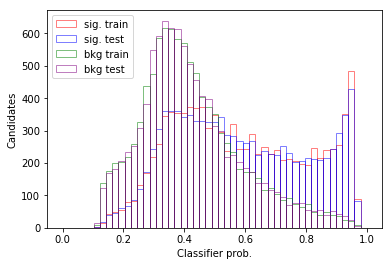

In [21]:
# Plot comparison of the distributions
#print(df_sig_tr.head(5))
#print(df_bkg_tr.head(5))
bins_pr = np.linspace(0, 1, 50)
plt.clf()
fig, ax1 = plt.subplots()
h_sig_train = df_sig_tr.hist(column=['prob'], ax = ax1, fill=False, edgecolor = 'red', bins = bins_pr, alpha=0.5, label="sig. train")
h_sig_test = df_sig_tst.hist(column=['prob'], ax = ax1, fill=False, edgecolor = 'blue', bins = bins_pr, alpha=0.5, label="sig. test")
h_bkg_train = df_bkg_tr.hist(column=['prob'], ax = ax1, edgecolor = 'green', fill=False, bins = bins_pr, alpha=0.5, label="bkg train")
h_bkg_test = df_bkg_tst.hist(column=['prob'], ax = ax1, fill=False, edgecolor = 'purple', bins = bins_pr, alpha=0.5, label="bkg test")
prepPlot(ax1, "Classifier prob.", "Candidates")
plt.legend()
plt.savefig('output_comp_GPD.png')
plt.show()

In [22]:
# Save classifier and scaler
classifier.save('classifier_GPDexample.h5')
joblib.dump(scaler, 'scaler_GPDexample.pkl')

['scaler_GPDexample.pkl']